In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
from itertools import product, combinations_with_replacement
from tqdm import tqdm
import os
import sys

from neural_network import NeuralNetwork
from methods import *
from data_gen import FrankeDataGen, CancerData
from grad_desc import Model

np.random.seed(4155) # FYS-STK4155 

In [2]:
# unit tests
#!python -m unittest tests.py

In [3]:
# seaborn plot settings
sns.set_style("whitegrid")  # Options: "darkgrid", "whitegrid", "dark", "white", "ticks"
sns.set_context("notebook", font_scale=1.2)  # Options: "paper", "notebook", "talk", "poster"

# Set color palette
sns.set_palette("muted")

# Franke funtion

### Find a good model structure

The number of layers, the size of each layer and the activation functions

In [4]:
# importing data 
data = FrankeDataGen(noise=True)
x_data = jnp.column_stack((data.x.flatten(), data.y.flatten()))  
y_data = data.z.ravel().reshape(-1, 1) 

# splitting data
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)
inputs = X_train, X_test 
targets = y_train, y_test

In [5]:
batch_size = 1000
lr = 0.01
epochs = 20

learning_strats = ["Constant", "Momentum", "Adam", "Adagrad_Momentum", "RMSprop", "Adagrad"]

input_size = 2
output_size = 1
hidden_layers = [4,4]
network_shape = [input_size] + hidden_layers + [output_size]
activation_funcs = ["sigmoid", "sigmoid", "identity"]
cost_fun = "MSE"

# trying to find out which of these are good enough to use for the inital search for a good model structure 

test_loss = []
test_accuracy = []  

for learning_strat in learning_strats:
    model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "continuous", learning_strat)
    model.train_network(inputs, targets, epochs=epochs, learning_rate=lr, batch_size=batch_size)
    test_loss.append(model.test_loss)
    test_accuracy.append(model.test_accuracy)

Best method: Adam


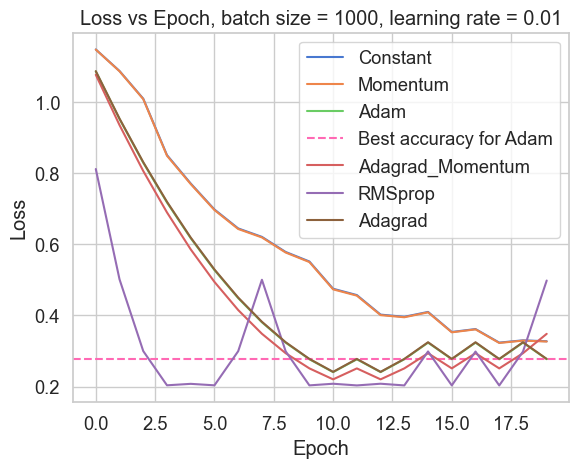

In [6]:
min_loss = np.inf
min_loss_idx = 0
for i, loss in enumerate(test_loss):
    if loss[-1] < min_loss:
        min_loss = loss[-1]
        min_loss_idx = i
        best_method = learning_strats[i]
        
print(f"Best method: {learning_strats[min_loss_idx]}")

for method, loss_list in zip(learning_strats, test_loss):
        plt.plot(loss_list, label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {lr}")
        if method == best_method:
                plt.axhline(y=min_loss, linestyle='--', label=f"Best accuracy for {method}", color="hotpink")
        plt.legend()
plt.show()

From now we will use Adam optimizer, lr = 0.01, batch size = 1000 and epochs = 100 to explore the structure and activation functions of our neural network.

In [7]:
layer_size = [4, 8]#, 16, 32]
hidden_layers = [2, 3]#, 4]
# will be 336

input_size = 2 
output_size = 1 
activation_funcs = ["ReLU"] * (max(hidden_layers) + 1)  
cost_fun = "MSE"  
epochs = 50
lr = 0.01  
batch_size = 1000


test_loss = []
test_accuracy = []

for layers in hidden_layers:

    for sizes in product(layer_size, repeat=layers):

        network_shape = [input_size] + list(sizes) + [output_size]
        
        model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "continuous", best_method)
        model.train_network(inputs, targets, epochs=epochs, learning_rate=lr, batch_size=batch_size)
        
        test_loss.append(model.test_loss)
        test_accuracy.append(model.test_accuracy)

test_loss = np.array(test_loss)
test_accuracy = np.array(test_accuracy)

# save data to file
np.save("test_loss.npy", test_loss)

In [8]:
permutations = []

for layers in hidden_layers:
    for sizes in product(layer_size, repeat=layers):
        permutations.append(sizes)

Best structure: [4, 4, 8]


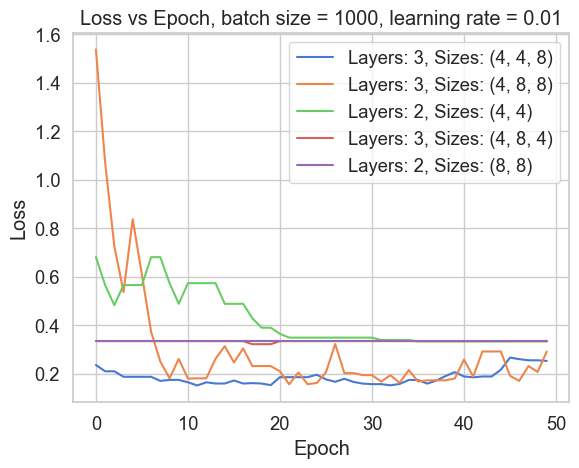

In [9]:

data = []
total_configs = 0  

for layers in hidden_layers:
    for sizes in product(layer_size, repeat=layers):
        loss_value = test_loss[total_configs]  
        data.append([layers, str(sizes), loss_value[-1]])  
        total_configs += 1  

df = pd.DataFrame(data, columns=["Num Hidden Layers", "Permutations", "Final Loss"])
df = df.sort_values(by="Final Loss")

num = 5
best_configs = df.index[:num]

# the very best
best_structure = df.iloc[0]["Permutations"]
best_structure_list = [int(x) for x in best_structure.strip("()").split(",")]
print(f"Best structure: {best_structure_list}")


for i in best_configs:
    plt.plot(test_loss[i], label=f"Layers: {df['Num Hidden Layers'][i]}, Sizes: {df['Permutations'][i]}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {lr}")
    plt.legend()

plt.show()

In [10]:
sys.exit()

SystemExit: 

/Users/miamerlid/anaconda3/envs/fysstk/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


We choose our best structure to be:

We furthermore must look at the different activation functions. We will try the following for the hidden layers: ReLU, Sigmoid and leaky ReLU. For the output layer we will use a linear activation function, i.e. no activation function.

In [11]:
activation_functions = ["ReLU", "leaky_ReLU", "sigmoid"]
best_structure_list = [int(x) for x in best_structure.strip("()").split(",")]
num_layers = len(best_structure_list)
combinations = list(product(activation_functions, repeat=num_layers))

test_loss = []

for comb in combinations:
    model = NeuralNetwork([input_size] + best_structure_list + [output_size], comb, cost_fun, "continuous", best_method)
    model.train_network(inputs, targets, epochs=epochs, learning_rate=lr, batch_size=batch_size)
    test_loss.append(model.test_loss)

Best activation functions: ['sigmoid', 'sigmoid', 'sigmoid']


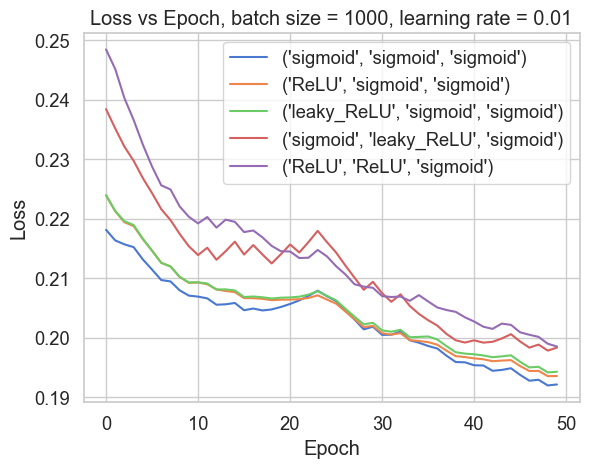

In [12]:
data = []
total_configs = 0

for comb in combinations:
    loss_value = test_loss[total_configs]
    data.append([str(comb), loss_value[-1]])
    total_configs += 1

df = pd.DataFrame(data, columns=["Activation Functions", "Final Loss"])
df = df.sort_values(by="Final Loss")


best_activation_funcs = df.iloc[0]["Activation Functions"]
best_activation_funcs_list = [x.strip().strip("'\"") for x in best_activation_funcs.strip("()").split(",")]
print(f"Best activation functions: {best_activation_funcs_list}")


num = 5
best_configs = df.index[:num]

for i in best_configs:
    plt.plot(test_loss[i], label=f"{df['Activation Functions'][i]}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {lr}")
    plt.legend()

plt.show()


We choose the best combination of activation functions to be: 

We will now do a grid search of the learning rate and the batch size to find the best combination of these hyperparameters. We will use the best structure and activation functions found above. We will do this for each of the optimizers. 

In [13]:
sys.exit()

SystemExit: 

/Users/miamerlid/anaconda3/envs/fysstk/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
learning_rates = [0.01, 0.001, 0.0005, 0.0001]
batch_sizes = [100, 1000, 3000, 8000]

network_shape = [input_size] + best_structure_list + [output_size]
activation_funcs = best_activation_funcs_list


def grid_search(learning_rates, batch_sizes, optimizer):
    test_loss = []  # This will store lists of losses for each learning rate
    
    for lr in learning_rates:
        lr_losses = []  # Store losses for each batch size for the current learning rate
        for batch_size in batch_sizes:
            model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "continuous", optimizer)
            model.train_network(inputs, targets, epochs=epochs, learning_rate=lr, batch_size=batch_size)
            lr_losses.append(model.test_loss)  # Append the final test loss for the current batch size
            
        test_loss.append(lr_losses)  # Append list of losses for this learning rate
    
    return np.array(test_loss)

In [15]:
grid = {}

# Perform grid search for each optimizer and collect test losses
for optimizer in learning_strats:
    test_loss = grid_search(learning_rates, batch_sizes, optimizer)  # Get the final loss matrix
    grid[optimizer] = test_loss  

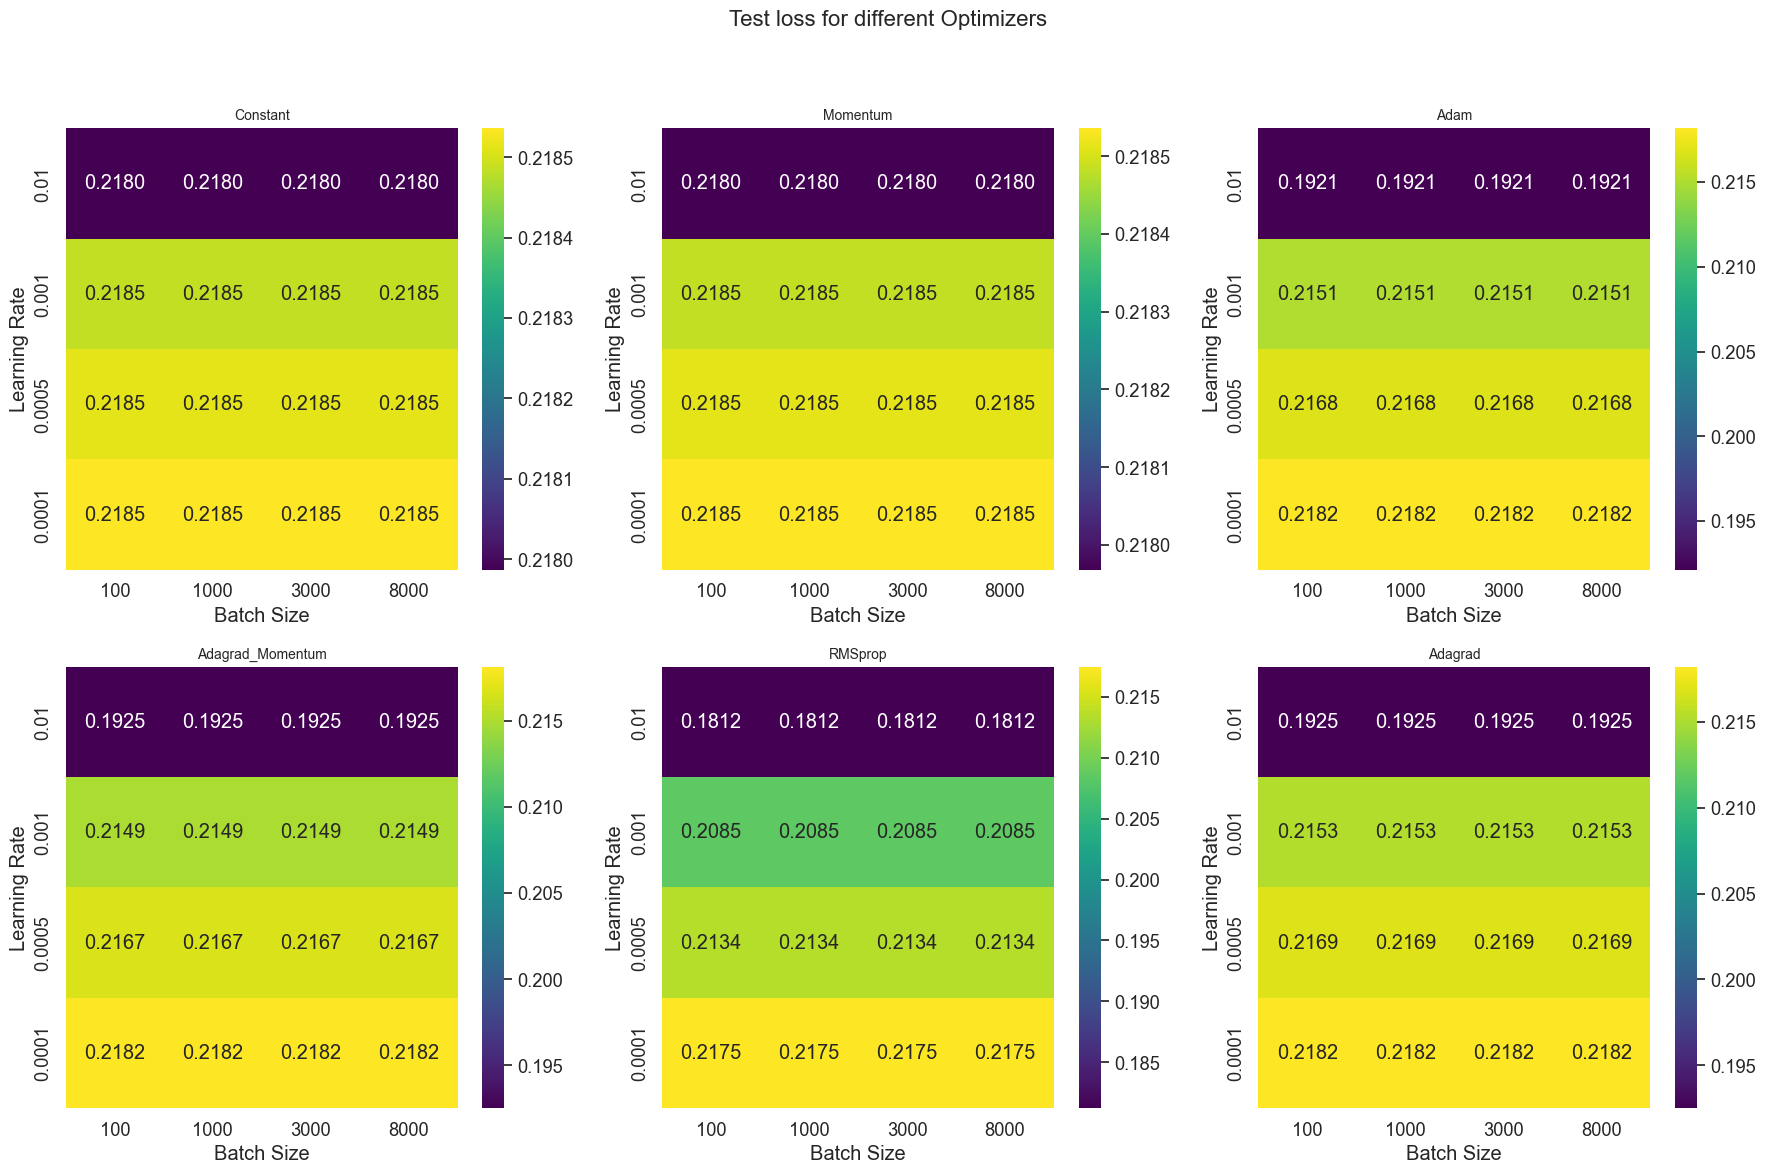

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust size as necessary
axes = axes.flatten() 

for i, (optimizer, loss_matrix) in enumerate(grid.items()):
    loss_matrix = loss_matrix[:, :, -1]  # Extract the last loss for each combination

    # Plotting the heatmap on the corresponding axis
    sns.heatmap(loss_matrix, annot=True, fmt=".4f", 
                 xticklabels=batch_sizes, 
                 yticklabels=learning_rates, 
                 cmap="viridis", ax=axes[i])  # Specify the axis to plot on
    
    axes[i].set_xlabel("Batch Size")
    axes[i].set_ylabel("Learning Rate")
    axes[i].set_title(f"{optimizer}", fontsize=10)  # Smaller title for the optimizer

# Add a main title for the entire figure
plt.suptitle("Test loss for different Optimizers", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

In [17]:
# Find the best combination for each optimizer
best_combinations = {}

for optimizer, loss_matrix in grid.items():
    min_loss = np.inf
    min_idx = (0, 0)

    # Extract the last loss values for comparison
    loss_matrix_final = loss_matrix[:, :, -1]
    
    # Iterate through the loss_matrix_final to find the minimum loss and corresponding indices
    for i in range(loss_matrix_final.shape[0]):  # Loop through rows (learning rates)
        for j in range(loss_matrix_final.shape[1]):  # Loop through columns (batch sizes)
            # Directly compare scalar values
            if loss_matrix_final[i, j] < min_loss:
                min_loss = loss_matrix_final[i, j]  # Use loss_matrix_final for the minimum loss
                min_idx = (i, j)
    
    best_combinations[optimizer] = (min_idx, min_loss)

# Print out the best combinations for each optimizer
for optimizer, (idx, loss) in best_combinations.items():
    lr = learning_rates[idx[0]]  # Get the learning rate
    batch_size = batch_sizes[idx[1]]  # Get the batch size
    print(f"{optimizer}: Learning Rate: {lr}, Batch Size: {batch_size}, Final loss: {loss:.4f}")


Constant: Learning Rate: 0.01, Batch Size: 100, Final loss: 0.2180
Momentum: Learning Rate: 0.01, Batch Size: 100, Final loss: 0.2180
Adam: Learning Rate: 0.01, Batch Size: 100, Final loss: 0.1921
Adagrad_Momentum: Learning Rate: 0.01, Batch Size: 100, Final loss: 0.1925
RMSprop: Learning Rate: 0.01, Batch Size: 100, Final loss: 0.1812
Adagrad: Learning Rate: 0.01, Batch Size: 100, Final loss: 0.1925


Lastly, we present a plot of the loss history for the best model for each of the optimizers. 

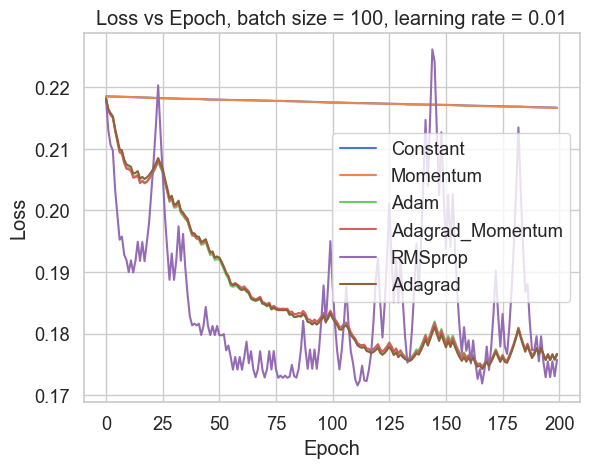

In [18]:
# plot the test loss for the best combination of hyperparameters
epochs_long = 200

best_combinations = {k: v for k, v in best_combinations.items() if v[1] != np.inf}

for optimizer, (idx, loss) in best_combinations.items():
    lr = learning_rates[idx[0]]
    batch_size = batch_sizes[idx[1]]
    
    model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "continuous", optimizer)
    model.train_network(inputs, targets, epochs=epochs_long, learning_rate=lr, batch_size=batch_size)
    
    plt.plot(model.test_loss, label=optimizer)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {lr}")
    plt.legend()

The very best model is found to be: 

### Classification

In [19]:
def create_filename(learning_strategy, batch_size, learning_rate):
    return f"../models_Cancer/strat-{learning_strategy}_bs-{batch_size}_lr-{learning_rate}.json"

In [20]:
data = CancerData()
x_data = np.array(data.x)
y_data = np.array(data.y)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)
inputs = (X_train, X_test)
targets = (y_train, y_test)

Dataset URL: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data


In [21]:
input_size = 30
output_size = 1
hidden_layers = [32, 16]
network_shape = [input_size] + hidden_layers + [output_size]
activation_funcs = ["ReLU", "ReLU", "sigmoid"]
cost_fun = "BinaryCrossEntropy"

In [22]:
learning_strats = ["Constant", "Momentum", "Adagrad_Momentum", "Adam", "RMSprop", "Adagrad"]
epochs = 100
learning_rates = [0.1, 0.01, 0.001, 0.0001] 
batch_sizes = [32, 64, 128, 256, 512, 1024]

In [23]:


for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for learning_strat in learning_strats:

            filename = create_filename(learning_strat, batch_size, learning_rate)
            if os.path.exists(filename):
                print(f"Model already exists: {filename}")
                continue

            print(f"Training model: {filename}")
            model = NeuralNetwork(network_shape=network_shape, activation_funcs=activation_funcs, cost_func=cost_fun, type_of_network="classification", update_strategy=learning_strat)
            model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
            model.save_network(filename)

            print(f"Model saved: {filename}")

Model already exists: ../models_Cancer/strat-Constant_bs-32_lr-0.1.json
Model already exists: ../models_Cancer/strat-Momentum_bs-32_lr-0.1.json
Model already exists: ../models_Cancer/strat-Adagrad_Momentum_bs-32_lr-0.1.json
Model already exists: ../models_Cancer/strat-Adam_bs-32_lr-0.1.json
Model already exists: ../models_Cancer/strat-RMSprop_bs-32_lr-0.1.json
Model already exists: ../models_Cancer/strat-Adagrad_bs-32_lr-0.1.json
Model already exists: ../models_Cancer/strat-Constant_bs-64_lr-0.1.json
Model already exists: ../models_Cancer/strat-Momentum_bs-64_lr-0.1.json
Model already exists: ../models_Cancer/strat-Adagrad_Momentum_bs-64_lr-0.1.json
Model already exists: ../models_Cancer/strat-Adam_bs-64_lr-0.1.json
Model already exists: ../models_Cancer/strat-RMSprop_bs-64_lr-0.1.json
Model already exists: ../models_Cancer/strat-Adagrad_bs-64_lr-0.1.json
Model already exists: ../models_Cancer/strat-Constant_bs-128_lr-0.1.json
Model already exists: ../models_Cancer/strat-Momentum_bs-12

ValueError: Recall value outside the range [0, 1]: 328.0

In [14]:
losses = []
accuracies = []
losses_test = []
accuracies_test = []

learning_rate = 0.01
batch_size = 32

for learning_strat in tqdm(learning_strats):
    model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "classification", learning_strat, manual_gradients=True)
    model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    losses.append(model.loss)
    accuracies.append(model.accuracy)
    losses_test.append(model.test_loss)
    accuracies_test.append(model.test_accuracy)

100%|██████████| 6/6 [00:23<00:00,  3.97s/it]


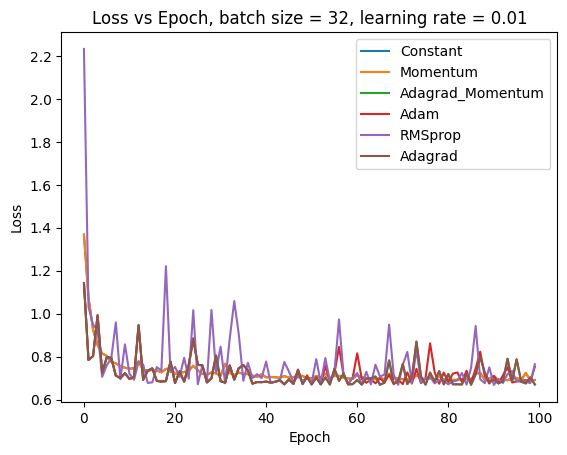

In [15]:
i = 0

for method, loss_list in zip(learning_strats, losses_test):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(loss_list, label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()

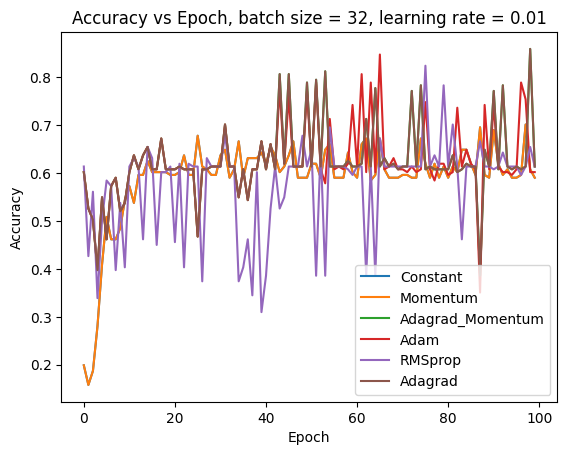

In [16]:
i = 0
for method, accuracy_list in zip(learning_strats, accuracies_test):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(accuracy_list[:], label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()

In [21]:
# load the models and continue training
losses = []
accuracies = []
losses_test = []
accuracies_test = []

for learning_strat in learning_strats:
    file_name = create_filename(learning_strat, batch_size, learning_rate)
    model = NeuralNetwork.load_network(file_name=file_name)
    _, accuracy_list, loss_list, accuracy_test, loss_test  = model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    losses.append(loss_list)
    accuracies.append(accuracy_list)
    losses_test.append(loss_test)
    accuracies_test.append(accuracy_test)
    model.save_network(file_name)

100%|██████████| 2/2 [00:00<00:00, 278.63it/s]


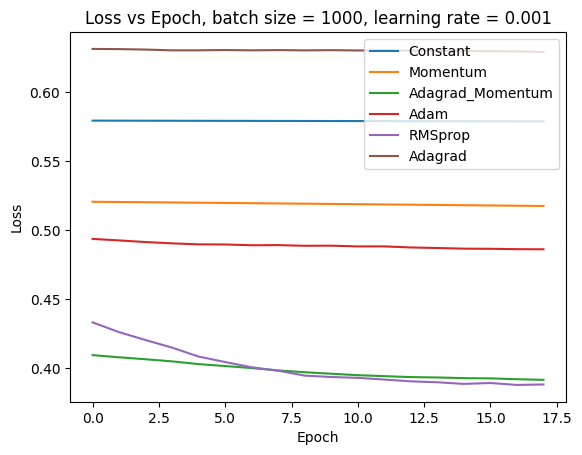

In [22]:
# plot 
i = 0
for method, loss_list in zip(learning_strats, losses):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(loss_list, label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
    

In [11]:
# stop running the notebook here
sys.exit()

SystemExit: 

/Users/miamerlid/anaconda3/envs/fysstk/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Regression


In [10]:
input_size = 2
output_size = 1
hidden_layers = [32, 16, 8]
network_shape = [input_size] + hidden_layers + [output_size]
activation_funcs = ["sigmoid", "sigmoid", "sigmoid", "identity"]
cost_fun = mse

epochs = 100
learning_rate = 0.001
batch_size = 1000

In [11]:
data = FrankeDataGen(noise=False)
inputs = jnp.column_stack((data.x.flatten(), data.y.flatten()))  
print(len(inputs))
targets = data.z.ravel().reshape(-1, 1)   

10201


In [12]:
learning_strats = ["Constant", "Momentum","Adagrad_Momentum", "Adam", "RMSprop", "Adagrad"]
losses = []
accuracies = []

for learning_strat in tqdm(learning_strats):
    model = NeuralNetwork(network_shape, activation_funcs, cost_fun, "regression", learning_strat, manual_gradients=True)
    _, accuracy_list, loss_list, preds = model.train_network(inputs, targets, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    losses.append(loss_list)
    accuracies.append(accuracy_list)

100%|██████████| 6/6 [00:19<00:00,  3.32s/it]


In [18]:
print(len(losses[0]))

100


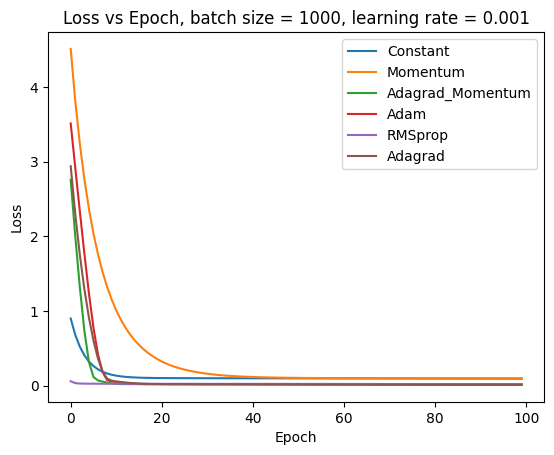

In [19]:
i = 0

for method, loss_list in zip(learning_strats, losses):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(loss_list[:], label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Loss vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()

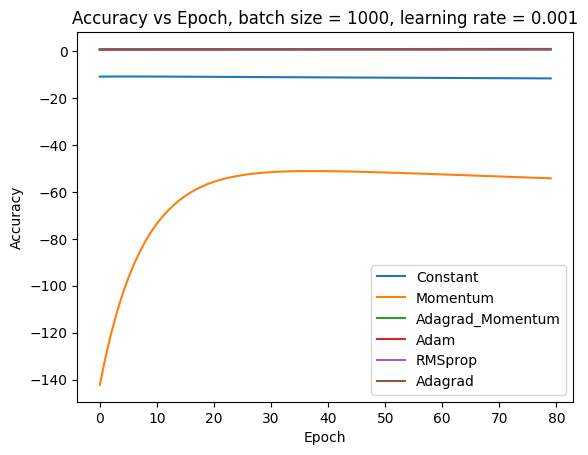

In [22]:
i = 0
for method, accuracy_list in zip(learning_strats, accuracies):
    if i in [0, 1, 2,3,4,5]:
        plt.plot(accuracy_list[20:], label=method)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy vs Epoch, batch size = {batch_size}, learning rate = {learning_rate}")
        plt.legend()
    i += 1
plt.show()